# Huấn luyện

## Cài đặt môi trường

```{note}
Môi trường mình dùng là Google Colabotory free, cũng đủ dùng với dataset nhỏ và thời gian train ngắn như bài này.
Sau khi làm xong các bước chuẩn bị dữ liệu, hãy copy file `<dataset>.h5` lên Google Drive, tạo một notebook google colabotory và bắt đầu làm các bước trong notebook dưới đây
```

* Gắn drive làm ổ cứng, nơi lưu dữ liệu của notebook . Hiện tại thì đã có giao diện ở thanh công cụ bên tay trái screen, nếu thích trực quan thì các bạn hãy dùng thanh công cụ đó thay cho các dòng code mount disk bên dưới.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* Import các thư viện cần thiết, chuyển working directory sang nơi chứa file <dataset>.h5

In [2]:
import tensorflow as tf
import keras
import cv2
import numpy as np
import os
import h5py
from matplotlib import pyplot as plt
import time
os.chdir('./drive/My Drive/GG_colab/CDTproject') #hãy thay đổi theo nơi lưu <dataset>.h5

In [3]:
tf.__version__

'2.4.1'

* Load dataset từ file h5py

In [4]:
with h5py.File("train_data_100_18-02.h5",'r') as F:
    x_train = np.array(F.get("x_train"))
    y_train = np.array(F.get("y_train"))
    x_test = np.array(F.get("x_test"))
    y_test = np.array(F.get("y_test"))

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)


(2689, 100, 100, 3) (2689, 6)
(350, 100, 100, 3) (350, 6)


## Tạo kiến trúc của mô hình CNN

```{note}
Ở đây dùng các layer Convolutional bình thường kết hợp với Bottleneck residual block của MobileNet.
```

* Code khối bottleneck residual block

In [9]:
def bottleneck_res_block(block_input,factor):
  ###expansion convolution layer
  x = keras.layers.Conv2D(int(factor)*int(block_input.shape[3]),(1,1))(block_input) 
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU(max_value = 6)(x)
  
  ###depthwise convolution layer
  x = keras.layers.DepthwiseConv2D((3,3),padding = 'same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU(max_value = 6)(x)
  
  ###projection convolution layer
  x = keras.layers.Conv2D(int(int(x.shape[3])/int(factor)),(1,1))(x)
  x = keras.layers.BatchNormalization()(x)
  #x = keras.layers.ReLU(max_value = 6)(x)
  
  #Residual connect
  x = keras.layers.Add()([x,block_input])
  x = keras.layers.Dropout(rate = 0.5)(x)
  
  return x

* Đưa vào mô hình, tạo ra model hoàn chỉnh để train

In [10]:
def Tomato_model(input_shape):
  x_input = keras.layers.Input(input_shape)
  
  x = keras.layers.Conv2D(32,(1,1),padding = 'same')(x_input)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.MaxPool2D((2,2))(x)
  x = keras.layers.ReLU(max_value = 6)(x)
  x = keras.layers.Dropout(rate = 0.2)(x)
  x = bottleneck_res_block(x,2)
  x = keras.layers.AveragePooling2D((2,2))(x)
  x = bottleneck_res_block(x,2)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(6,activation = 'softmax')(x)
  
  model = keras.models.Model(inputs = x_input, outputs = x)
  
  return model

* Thông số của mô hình

In [11]:
model = Tomato_model((100,100,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 32) 128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 100, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 50, 50, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Huấn luyện mô hình vừa khởi tạo

* Khởi tạo optimizer, loss và metrics cho model, bắt đầu huấn luyện mô hình theo tỉ lệ train/valid là 8:2 

In [12]:
model.compile(optimizer ='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

* Chuyển param mode trong dòng `checkpoint` thành `best` nếu chỉ muốn lưu model có độ chính xác trên tập validation lớn nhất
* `filepath` là format đường dẫn của những model lưu xuống trong khi train, có thể thay đổi tùy ý

In [13]:
filepath="trained_model/size_100_18-02/weights.100.{epoch:02d}-{val_accuracy:.2f}.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, mode='auto') # change 'auto' to 'best' if needed
callbacks_list = [checkpoint]
model.fit(x = x_train, y = y_train, epochs = 300,validation_split=0.2,callbacks = callbacks_list)

Epoch 1/300
60/60 [==============================] - 36s 43ms/step - loss: 1.3388 - accuracy: 0.5213 - val_loss: 1.8314 - val_accuracy: 0.1814
Epoch 2/300
60/60 [==============================] - 2s 31ms/step - loss: 0.5242 - accuracy: 0.8367 - val_loss: 1.9896 - val_accuracy: 0.1392
Epoch 3/300
60/60 [==============================] - 2s 32ms/step - loss: 0.4235 - accuracy: 0.8678 - val_loss: 2.3452 - val_accuracy: 0.2785
Epoch 4/300
60/60 [==============================] - 2s 32ms/step - loss: 0.3040 - accuracy: 0.9059 - val_loss: 3.0306 - val_accuracy: 0.1730
Epoch 5/300
60/60 [==============================] - 2s 32ms/step - loss: 0.2901 - accuracy: 0.9038 - val_loss: 3.3912 - val_accuracy: 0.1688
Epoch 6/300
60/60 [==============================] - 2s 32ms/step - loss: 0.2203 - accuracy: 0.9297 - val_loss: 3.3681 - val_accuracy: 0.2384
Epoch 7/300
60/60 [==============================] - 2s 32ms/step - loss: 0.1919 - accuracy: 0.9476 - val_loss: 1.9309 - val_accuracy: 0.4873
Epoch

* Vẽ loss và accuracy của quá trình huấn luyện lên đồ thị để quan sát sự thay đổi và đưa ra đánh giá

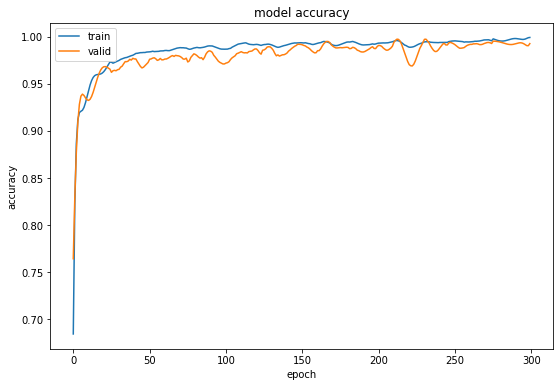

In [ ]:
"""
Accuracy
"""
#Hàm savgol_filter để làm đồ thị mượt hơn, có thể dùng cho đẹp
from scipy.signal import savgol_filter
from numpy import log as ln
from numpy import log10 as log
history = model.history
acc = savgol_filter(history.history['acc'],51,10)
val_acc = savgol_filter(history.history['val_acc'],51,10)
plt.rcParams["figure.figsize"] = (9,6)
plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

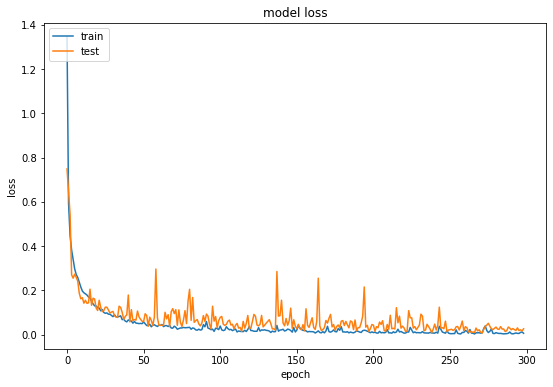

In [ ]:
"""
Loss
"""
# summarize history for loss
plt.plot(history.history['loss'][0:299])
plt.plot(history.history['val_loss'][0:299])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


* Sau khi huấn luyện và đánh giá xong, chọn mô hình tốt nhất để triển khai lên hệ thống phân loại, model file sẽ có dạng <weight>.h5